# Part 3: Subreddit Data Modeling
In this phase of the project, we will be using data collected in Part 1 coupled with the analysis from Part 2 to create our data model

**Import Packages**

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [73]:
df = pd.read_csv("../data/women_men.csv")
df = df[df['author']!="AutoModerator"]
df = df[df['author']!="splat_bot"]
df.head(3)

,Unnamed: 0,id,subreddit,created_utc,is_video,spoiler,is_self,score,is_original_content,is_created_from_ads_ui,...,selftext,all_text,title_length,selftext_length,all_text_length,title_words,selftext_words,all_text_words,no_links_text,contains_link
0,1,ko13ed,AskWomen,12/31/20 19:04,False,False,True,1,False,NaN,...,NaN,What about the feminist movement can be improv...,49,0,50,8,0,8,What about the feminist movement can be improv...,0
1,2,ko13oa,AskWomen,12/31/20 19:04,False,False,True,1,False,NaN,...,NaN,Should I forget about a love life if I have a ...,72,0,73,17,0,17,Should I forget about a love life if I have a ...,0
2,3,ko17g3,AskWomen,12/31/20 19:10,False,False,True,1,False,NaN,...,NaN,How long into dating should you introduce your...,66,0,67,12,0,12,How long into dating should you introduce your...,0


## What is the baseline accuracy rate?

In [74]:
df.subreddit.value_counts()

AskWomen    10344
AskMen       8037
Name: subreddit, dtype: int64

In [75]:
def get_scores(model):
    model.fit(X_train,y_train)
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    result_dict =  {'Train Score': train_score,'Test Score': test_score}
    return result_dict

def plot_confusion(model, title):
    model.fit(X_train,y_train)
    plot_confusion_matrix(model, X_test, y_test, cmap="Blues")
    plt.title(title);
    return plot_confusion

def get_preds_df(model):
    model.fit(X_train,y_train)
    y_preds = model.predict(X_test)
    results = pd.merge(X_test,y_test, left_index=True, right_index=True).reset_index()
    results['prediction'] = y_preds
    results['outcome'] = results['prediction'] == results['subreddit']
    return results

In [76]:
X = df['no_links_text']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, stratify=y, test_size=0.2)

## 3.1. Logistic Regression Model

- Create different variations of Log Reg Models
- Try CountVectorizer vs. TfidfVectorizer
- Try tuning parameters with a grid search

### Logistic Regression using CountVectorizer CV

In [78]:
pipe_cv_log = Pipeline([
    ('cv',CountVectorizer()),
    ('log', LogisticRegressionCV(solver='liblinear', max_iter=1000))
])

pipe_cv_log.fit(X_train,y_train)
get_scores(pipe_cv_log)

{'Train Score': 0.8184167573449401, 'Test Score': 0.6847973891759587}

/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


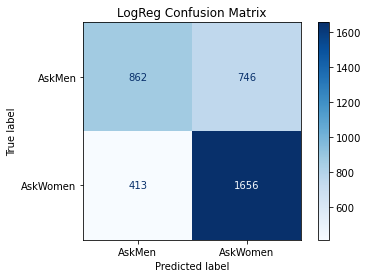

In [80]:
plot_confusion(pipe_cv_log, "LogReg Confusion Matrix");

In [174]:
results_cv_lr = get_preds_df(pipe_cv_lr)
mc_cv_lr = results_cv_lr[results_cv_lr.outcome==False]
mc_cv_lr.head(3)

,index,no_links_text,subreddit,prediction,outcome
3,638,Planning to buy one today - tips on getting th...,pelotoncycle,orangetheory,False
24,3782,Does it just mean that you shouldn’t grab onto...,orangetheory,pelotoncycle,False
26,1777,Ordering process,pelotoncycle,orangetheory,False


### Logistic Regression using TfidfVectorizer

In [82]:
pipe_tf_logreg = Pipeline([
    ('tfv',TfidfVectorizer()),
    ('logreg', LogisticRegressionCV(solver='liblinear', max_iter=1000))
])

pipe_tf_logreg.fit(X_train,y_train)
get_scores(pipe_tf_logreg)

{'Train Score': 0.8409276387377584, 'Test Score': 0.6894207234158282}

/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


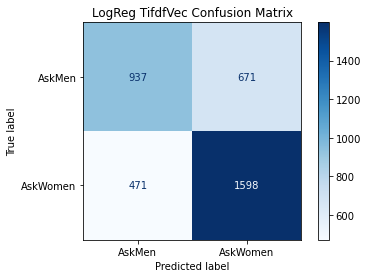

In [83]:
plot_confusion(pipe_tf_logreg, "LogReg TifdfVec Confusion Matrix");

In [35]:
tf_logreg_params  = {
    'tfv__stop_words': [None,"english"],
    'tfv__min_df': [1,2,3],
    'tfv__ngram_range': [(1, 1),(2,2),(1,2)]
}

gs = GridSearchCV(pipe_tf_logreg, param_grid=tf_logreg_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.7436831650104481


{'tfv__min_df': 1, 'tfv__ngram_range': (1, 2), 'tfv__stop_words': None}

In [84]:
pipe_tf_logreg_opt = Pipeline([
    ('tfv',TfidfVectorizer(stop_words=None, ngram_range=(1,2),
                            min_df=1)),
    ('logreg', LogisticRegressionCV(solver='liblinear'))
])

pipe_tf_logreg_opt.fit(X_train,y_train)
get_scores(pipe_tf_logreg_opt)

{'Train Score': 0.9553182807399347, 'Test Score': 0.7160728855044873}

/Users/tanyashapiro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


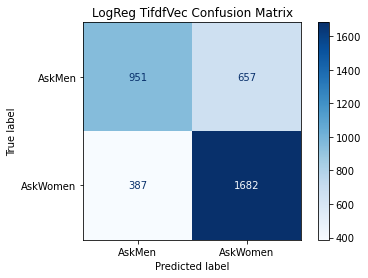

In [85]:
plot_confusion(pipe_tf_logreg_opt, "LogReg TifdfVec Confusion Matrix");

## 3.2. Random Forest Model

In [86]:
pipe_cv_rfc = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))]
)

pipe_cv_rfc.fit(X_train,y_train)
get_scores(pipe_cv_rfc)

{'Train Score': 0.9979597388465724, 'Test Score': 0.7182485722056023}

In [87]:
pipe_tf_rfc = Pipeline([
    ('tfv',TfidfVectorizer()),
    ('rfc', RandomForestClassifier(random_state=42))]
)

pipe_tf_rfc.fit(X_train,y_train)
get_scores(pipe_tf_rfc)

{'Train Score': 0.9978917301414582, 'Test Score': 0.7092738645635028}

In [70]:
rfc_params = {'rfc__n_estimators': [100, 150, 200],
              'cv__ngram_range':[(1,1),(1,2)]
            
}

gs = GridSearchCV(pipe_cv_rfc, param_grid=rfc_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

KeyboardInterrupt: 

In [88]:
pipe_cv_rfc_opt = Pipeline([
    ('cv',CountVectorizer(ngram_range=(1,2))),
    ('rfc', RandomForestClassifier(n_estimators=150, bootstrap=False, random_state=42))]
)

pipe_cv_rfc_opt.fit(X_train,y_train)
get_scores(pipe_cv_rfc_opt)

KeyboardInterrupt: 

In [72]:
plot_confusion(pipe_cv_rfc_opt, "Optimized Random Forest");

KeyboardInterrupt: 

### Export Best Model

In [15]:
import pickle
with open('../model/rfc_pipe.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(pipe_cv_rfc_opt, pickle_out)

In [56]:
preds = get_preds_df(pipe_cv_rfc_opt)

In [57]:
preds.to_csv('../data/predictions.csv')